In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

import sys; sys.path.append('../../')

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series
from models.ihme.dataloader import get_dataframes_cached

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from utils.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split, calculate_loss
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, get_forecast
from viz.forecast import plot_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [3]:
# for district in predictions_dict.keys():
#     district_dict = predictions_dict[district]
    
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-', color='C0', label='E / Hosp (M1)')
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-.', color='C0', label='I / Hosp (M1)')
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.ylabel('No of People')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
#     plt.grid()
#     plt.show()

## Load Covid19india Data

In [10]:
# dataframes = get_covid19india_api_data()
dataframes = get_dataframes_cached()

../../cache/dataframes_ts_04062020.pkl


In [11]:
predictions_dict = {}

## Select Districts to fit on

In [12]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

#districts_to_show = [('Maharashtra', 'Pune')]
districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [7]:
# for state, district in districts_to_show:
#    predictions_dict[(state, district)] = {}
#    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=7, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
#    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=0, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

Performing m1 fit ..
fetching from athenadb...
splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
39  maharashtra   mumbai 2020-05-22         27062.6       18979.4     7169.4   
40  maharashtra   mumbai 2020-05-23         28633.4       20125.6     7557.0   
41  maharashtra   mumbai 2020-05-24         30128.2       21171.2     7969.6   
42  maharashtra   mumbai 2020-05-25         31481.6       22092.2     8364.4   
43  maharashtra   mumbai 2020-05-26         32809.4       22914.6     8832.6   

    deceased  
39     913.8  
40     950.8  
41     987.4  
42    1025.0  
43    1062.2  
val
          state district       date  total_infected  hospitalised  recovered  \
0  maharashtra   mumbai 2020-05-27         34079.6       22561.0    10419.4   
1  maharashtra   mumbai 2020-05-28         35365.8       22215.0    12011.4   
2  maharashtra   mumbai 2020-05-29         36700.4       21910.8    13607.4   
3  maharashtra   m

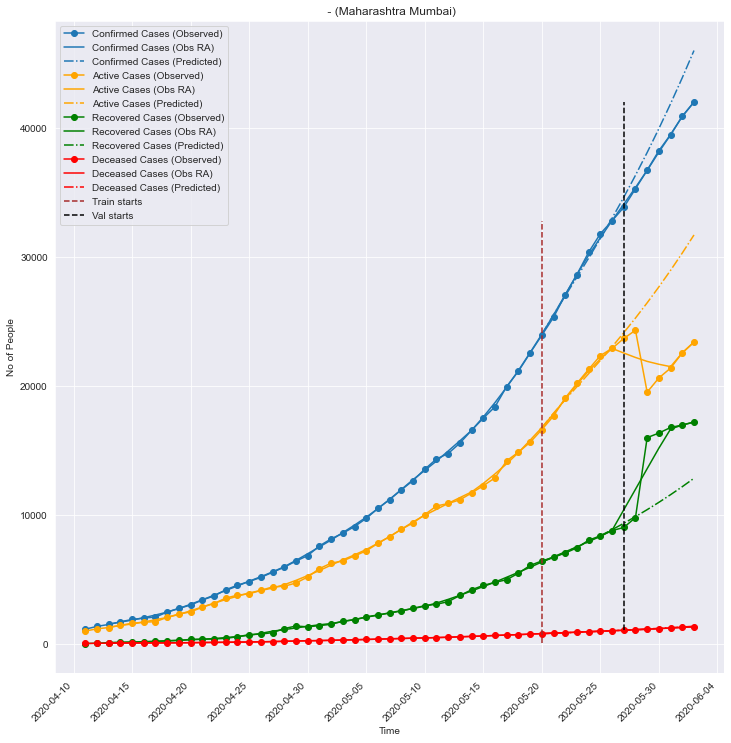

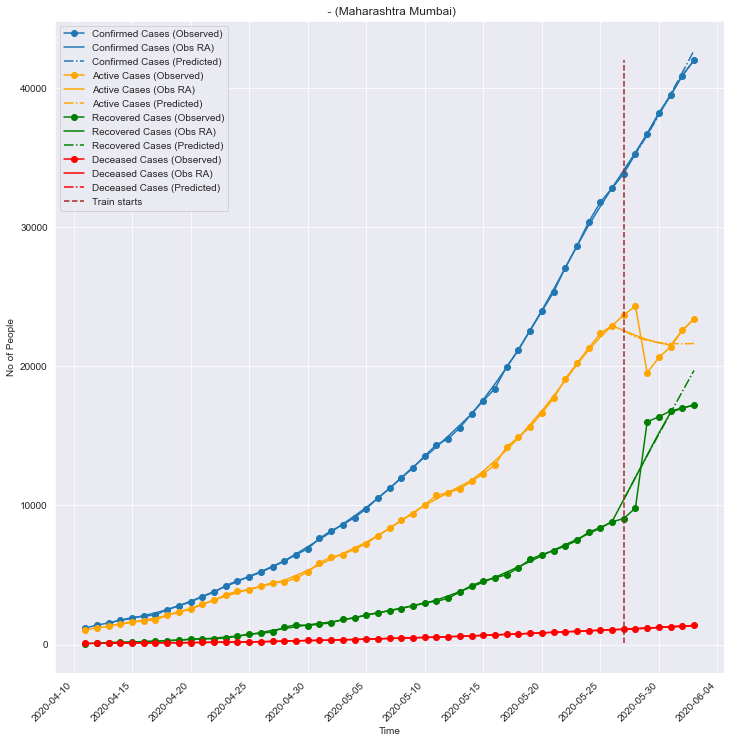

In [15]:
sns.set_style("dark")
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, 
        data_from_tracker=False,
        # filename='../../data/data/official-pune-21-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
    )
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, 
        data_from_tracker=False, 
        # filename='../../data/data/official-pune-25-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
    )

## Create Master Loss Dataframe

### M1 Loss

In [16]:
predictions_dict.keys()

dict_keys([('Maharashtra', 'Mumbai')])

In [17]:
predictions_dict[('Maharashtra','Mumbai')]['m1'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date', 'run_params'])

In [18]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in districts_to_show:
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         1.15           0.77     0.56      0.74   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai        19.29           4.89     1.99     32.02

### M2 Loss

In [19]:
#predictions_dict[('Maharashtra','Pune')]['m2']
predictions_dict[('Maharashtra','Mumbai')]['m2'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date', 'run_params'])

In [20]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         6.33           0.56     0.48     11.09

## Plot Forecasts

getting forecasts ..


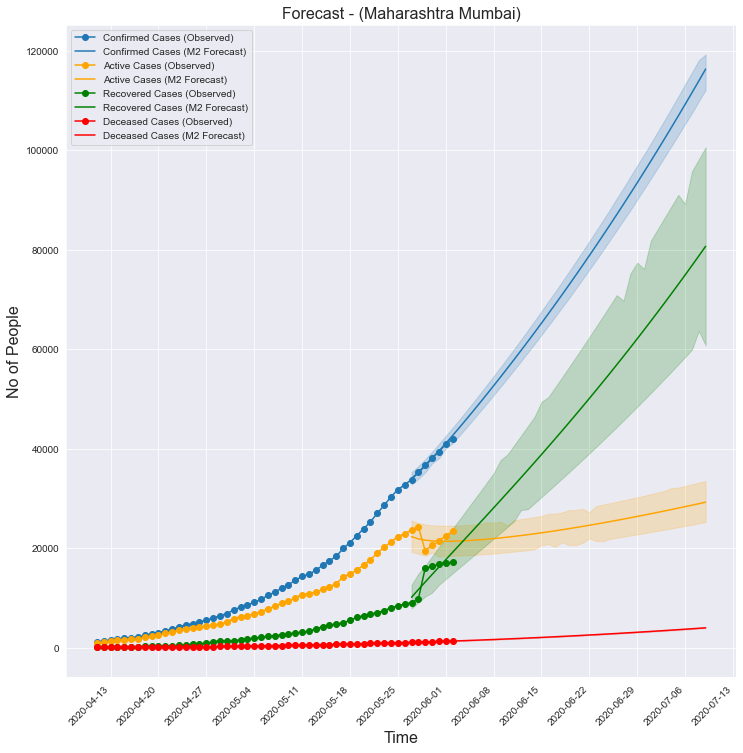

In [24]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [25]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [26]:
write_csv(df_output, '../../output-mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [27]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
#losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
losses_array[least_losses_indices][:10]

array([1.70653077, 1.73427904, 1.7678763 , 1.78331218, 1.90294611,
       2.02576721, 2.07056367, 2.12841921, 2.30788805, 2.34715494])

In [28]:
params_array = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [29]:
least_losses_indices[:10]

array([1309, 1161,  655,  787,  605, 1297,  789, 1385, 1377,  785])

In [30]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 0.2852079153360195, 'I_hosp_ratio': 0.3588243246738889, 'P_fatal': 0.06193339700538689, 'T_inc': 4.500921366824535, 'T_inf': 3.848462405065324, 'T_recov_severe': 44.986526316950034, 'lockdown_R0': 1.4055615029084076},
       {'E_hosp_ratio': 0.38139589117162787, 'I_hosp_ratio': 0.3373725204982703, 'P_fatal': 0.0627027515505167, 'T_inc': 4.484975064779788, 'T_inf': 3.915373668004645, 'T_recov_severe': 45.774071794276125, 'lockdown_R0': 1.2647376308418812},
       {'E_hosp_ratio': 0.3292717790725207, 'I_hosp_ratio': 0.35379353508139594, 'P_fatal': 0.06482265920202517, 'T_inc': 4.656676487087612, 'T_inf': 3.9188315041586153, 'T_recov_severe': 44.836858416568845, 'lockdown_R0': 1.3021631597107959},
       {'E_hosp_ratio': 0.34123062512997515, 'I_hosp_ratio': 0.3594209712962446, 'P_fatal': 0.06103139175479551, 'T_inc': 4.540550714204634, 'T_inf': 3.8440635817110347, 'T_recov_severe': 44.65868036387488, 'lockdown_R0': 1.292691207723465},
       {'E_hosp_ratio': 0.2121

In [31]:
#predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
#                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]
predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [32]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']

#sns.set_style("ticks")
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

In [33]:
df_true

state district       date  total_infected  hospitalised  recovered  \
46  maharashtra   mumbai 2020-04-11            1182          1036         71   
47  maharashtra   mumbai 2020-04-12            1399          1211         97   
48  maharashtra   mumbai 2020-04-13            1549          1308        141   
49  maharashtra   mumbai 2020-04-14            1753          1478        164   
50  maharashtra   mumbai 2020-04-15            1936          1642        181   
51  maharashtra   mumbai 2020-04-16            2043          1725        202   
52  maharashtra   mumbai 2020-04-17            2120          1760        239   
53  maharashtra   mumbai 2020-04-18            2509          2103        281   
54  maharashtra   mumbai 2020-04-19            2798          2357        310   
55  maharashtra   mumbai 2020-04-20            3050          2518        394   
56  maharashtra   mumbai 2020-04-21            3445          2887        408   
57  maharashtra   mumbai 2020-04-22            3754          3169        425   
58  maharashtra   mumbai 2020-04-23            4232          3591        473   
59  maharashtra   mumbai 2020-04-24            4589          3815        595   
60  maharashtra   mumbai 2020-04-25            4870          3917        762   
61  maharashtra   mumbai 2020-04-26            5194          4188        802   
62  maharashtra   mumbai 2020-04-27            5589          4455        915   
63  maharashtra   mumbai 2020-04-28            5982          4504       1234   
64  maharashtra   mumbai 2020-04-29            6457          4760       1427   
65  maharashtra   mumbai 2020-04-30            6874          5220       1364   
66  maharashtra   mumbai 2020-05-01            7625          5871       1459   
67  maharashtra   mumbai 2020-05-02            8172          6291       1559   
68  maharashtra   mumbai 2020-05-03            8613          6466       1804   
69  maharashtra   mumbai 2020-05-04            9123          6854       1908   
70  maharashtra   mumbai 2020-05-05            9758          7243       2128   
71  maharashtra   mumbai 2020-05-06           10527          7828       2287   
72  maharashtra   mumbai 2020-05-07           11219          8347       2435   
73  maharashtra   mumbai 2020-05-08           11967          8916       2589   
74  maharashtra   mumbai 2020-05-09           12689          9408       2792   
75  maharashtra   mumbai 2020-05-10           13564         10052       3004   
76  maharashtra   mumbai 2020-05-11           14355         10717       3110   
77  maharashtra   mumbai 2020-05-12           14781         10912       3313   
78  maharashtra   mumbai 2020-05-13           15581         11194       3791   
79  maharashtra   mumbai 2020-05-14           16579         11724       4234   
80  maharashtra   mumbai 2020-05-15           17512         12289       4568   
81  maharashtra   mumbai 2020-05-16           18396         12894       4806   
82  maharashtra   mumbai 2020-05-17           19967         14221       5012   
83  maharashtra   mumbai 2020-05-18           21152         14879       5516   
84  maharashtra   mumbai 2020-05-19           22563         15647       6116   
85  maharashtra   mumbai 2020-05-20           23935         16628       6466   
86  maharashtra   mumbai 2020-05-21           25317         17684       6751   
87  maharashtra   mumbai 2020-05-22           27068         19079       7080   
88  maharashtra   mumbai 2020-05-23           28634         20209       7476   
89  maharashtra   mumbai 2020-05-24           30359         21297       8074   
90  maharashtra   mumbai 2020-05-25           31789         22359       8404   
91  maharashtra   mumbai 2020-05-26           32791         22912       8814   
92  maharashtra   mumbai 2020-05-27           33835         23684       9054   
93  maharashtra   mumbai 2020-05-28           35273         24321       9817   
94  maharashtra   mumbai 2020-05-29           36710         19529      16008   
95  mahara

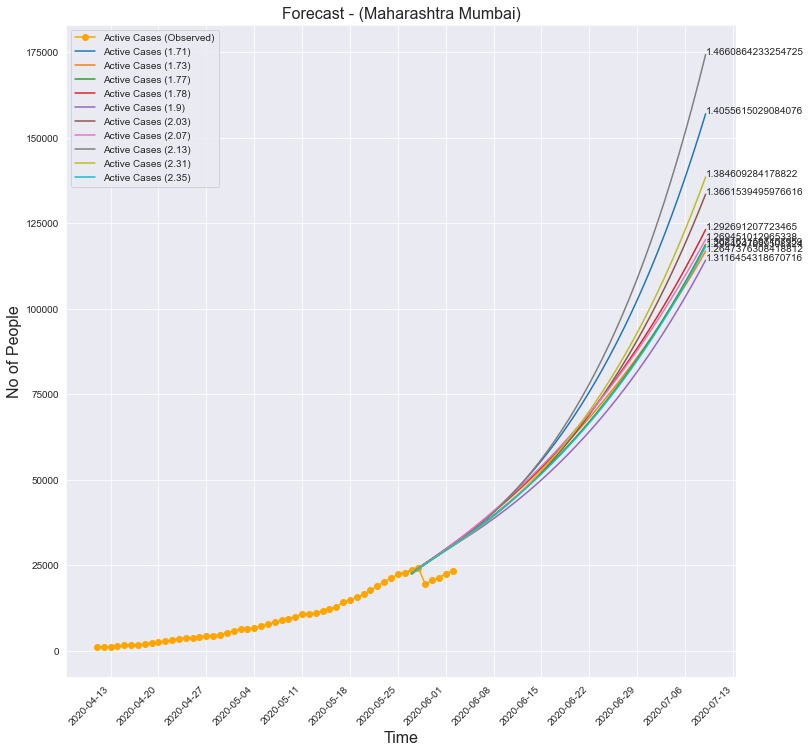

In [34]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = params_dict[i]['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
    #if true_r0 > 1.7:
    #    continue
    #if true_r0 == 0.59 or true_r0 == 1.04:
    #    continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

## Check varying R0 values

In [35]:
params_to_plot = \
{
    'low':{'E_hosp_ratio': 0.115406221316017, 'I_hosp_ratio': 0.4763871081949848, 'P_fatal': 0.050419345187462467, 'P_severe': 0.7809853621826006, 'T_inc': 4.484977212179257, 'T_inf': 3.3342249004558697, 'T_recov_severe': 52.054485355979445, 'lockdown_R0': 1.0974118812671074},
    'medium':{'E_hosp_ratio': 0.5105188613649609, 'I_hosp_ratio': 0.3039459885534656, 'P_fatal': 0.05832975188719784, 'P_severe': 0.8668707539589996, 'T_inc': 4.554494614633725, 'T_inf': 3.3958101193846915, 'T_recov_severe': 48.49542471232895, 'lockdown_R0': 1.1227557408135034},
    'high':   {'E_hosp_ratio': 0.2806960144261442, 'I_hosp_ratio': 0.3800638057872212, 'P_fatal': 0.05326820833691313, 'P_severe': 0.8339542948758695, 'T_inc': 4.304052648857938, 'T_inf': 3.4673218430188513, 'T_recov_severe': 47.044942872805294, 'lockdown_R0': 1.3444274930627533}
}
multipliers = [0.9, 1, 1.1, 1.25]
columns_for_csv = ['date', 'total_infected', 'hospitalised', 'recovered', 'deceased']


In [36]:
def set_r0_multiplier(params_dict, mul):
    new_params = params_dict.copy()
    new_params['post_lockdown_R0']= params_dict['lockdown_R0']*mul
    return new_params


predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=set_r0_multiplier(best_params_dict, mul)) \
                                 for mul in multipliers]

NameError: name 'best_params_dict' is not defined

In [ ]:
df_district = predictions_dict[districts_to_show[0]]['m2']['df_district']
df_train_nora, df_val_nora, df_true_fitting = train_val_split(
                df_district, train_rollingmean=False, val_rollingmean=False, val_size=0)

for key in params_to_plot:
    print("R0", params_to_plot[key]['lockdown_R0'])
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params = best_params_dict)
    df_loss = calculate_loss(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss)
    #print(df_loss.sum())

In [ ]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
params_array[least_losses_indices[:10]]
for key in params_to_plot:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params=set_r0_multiplier(best_params_dict, mul))
                                 for mul in multipliers]
    for i, df_prediction in enumerate(predictions_array_mul):
        filename = "Mumbai-" + key + "-" + str(multipliers[i]) + ".csv"
        print(filename)
        today = datetime.date.today().strftime("%Y-%m-%d")
        path = f'../../outputs/Mumbai-{today}/'
        if not os.path.exists(path):
            os.mkdir(path)
        df_prediction[columns_for_csv].to_csv(os.path.join(path, filename))
        #loss_value = np.around(np.sort(losses_array)[:10][i], 2)
        label = multipliers[i]
        true_r0 = label*best_params_dict['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
        #if true_r0 > 1.7:
        #    continue
        #if true_r0 == 0.59 or true_r0 == 1.04:
        #    continue
        sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                     ls='-', label='Active Cases ({})'.format(label))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    # plt.yscale('log')
    plt.xticks(rotation=45,horizontalalignment='right')

    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    plt.show()     

In [ ]:

for elt in params_array[least_losses_indices[:10]]:
    print("R0", elt['lockdown_R0'])
    #best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(
        predictions_dict[('Maharashtra', 'Mumbai')],
        train_fit = "m1",
        best_params = elt)
    df_loss = calculate_loss(
        df_train_nora, df_val_nora, df_predictions, train_period=7,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss.iloc[1])


In [ ]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = ('Maharashtra', 'Mumbai')

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1],
    regionType='district', best_params=params_dict,
    icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

In [ ]:
df_final.to_csv('../../outputs/mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [ ]:
df_final

In [ ]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['lockdown_R0']#*params_dict_temp['intervention_amount']
    #del params_dict_temp['intervention_amount']
    del params_dict_temp['lockdown_R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')

# Find beta and mean params for uncertainty estimation

In [326]:
params_array

array([{'E_hosp_ratio': 1.3317151570153074, 'I_hosp_ratio': 0.7189007948045418, 'P_fatal': 0.097473375724284, 'T_inc': 4.439579716297602, 'T_inf': 3.176281599427905, 'T_recov_severe': 37.339506121429636, 'lockdown_R0': 1.1201311271164238},
       {'E_hosp_ratio': 0.8915231243050661, 'I_hosp_ratio': 0.6553884209758865, 'P_fatal': 0.08754246757786033, 'T_inc': 4.07719325412367, 'T_inf': 3.482484156854608, 'T_recov_severe': 12.102776714203959, 'lockdown_R0': 1.2317108040519993},
       {'E_hosp_ratio': 1.3000094644941045, 'I_hosp_ratio': 0.400884748666979, 'P_fatal': 0.22698400568600557, 'T_inc': 4.79855953393592, 'T_inf': 3.2007701551077017, 'T_recov_severe': 10.055642976688468, 'lockdown_R0': 1.4393693328001844},
       ...,
       {'E_hosp_ratio': 0.5422148736555008, 'I_hosp_ratio': 0.45650157284406156, 'P_fatal': 0.03940174149216327, 'T_inc': 4.621586906790995, 'T_inf': 3.924808530595347, 'T_recov_severe': 48.53926989761297, 'lockdown_R0': 1.2988790978018097},
       {'E_hosp_ratio': 

In [340]:
params_list = list(params_array[0].keys())

In [378]:
num_samples

range(10, 2000, 10)

In [376]:
num_samples=range(10,2000,10)
betas= np.arange(0,5,0.2)
param_mean={}
param_stdev={}

params_fulldict = params_array[least_losses_indices]
params_list = list(params_array[0].keys())
means = {}
std_devs = {}
sums = {}
sqsums = {}

for i, beta in enumerate(betas):
    means[i] = {}
    std_devs[i] = {}
    for key in params_list:
        means[i][key] = []
        std_devs[i][key] = []
    for nums in num_samples:
        Loss_norm=0
        for key in params_list:
            sums[key] = 0
            sqsums[key] = 0
        tempdict = params_fulldict[0:nums]
        templosses = losses_array[least_losses_indices[0:nums]]
        for k in range(len(tempdict)):
            Loss_norm += np.exp(-beta*templosses[k])
            for key in params_list:
                sums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]
                sqsums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]**2
        for key in params_list:
            means[i][key].append(sums[key]/Loss_norm)
            std_devs[i][key].append(np.sqrt(sqsums[key]/Loss_norm-(sums[key]/Loss_norm)**2))
                

In [388]:
means[0]['E_hosp_ratio'][-5:]

[0.41102907055304116,
 0.41102907055304116,
 0.41102907055304116,
 0.41102907055304116,
 0.41102907055304116]

In [383]:
fig, axs = plt.subplots(len(params_list),2)
plt.rcParams['figure.dpi']=400
plt.rcParams['figure.figsize']=[50, 75]
plt.rcParams.update({'font.size':20})
colors =['blue','yellow','green','orange','red']
for row, key in enumerate(params_list):
    for idx, betaind in enumerate([0,2,5,10,24]):
        axs[row,0].plot(num_samples, means[betaind][key] , color = colors[idx],label=r'\beta=${:.1f}'.format(betas[betaind]))
        axs[row,0].set_title('{}'.format(key))
        axs[row,0].set(ylabel= "Estimated Mean")
        axs[row,1].plot(num_samples,std_devs[betaind][key], color = colors[idx],label=r'$\beta=${:.1f}'.format(betas[betaind]))
        axs[row,1].set_title('{}'.format(key))
        axs[row,1].set(ylabel="Estimated Std. Devn.")
        if (row==0):
            axs[row,0].legend(loc='center right')
        if (row==3):
            axs[row,0].set(xlabel="Number of top Hyperopt samples")
            axs[row,1].set(xlabel="Number of top Hyperopt samples")

fig.tight_layout(pad=1.0)

In [369]:
# Define N from plots!
N = 1500

In [374]:
len(means[i][key])

149

In [398]:
def get_loss(i):
    skip_length = 10
    mean_params = {key:means[i][key][N // skip_length] for key in params_list}
    df_train = predictions_dict[districts_to_show[0]]['m1']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m1']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m1',
                                best_params=mean_params)
    df_loss = calculate_loss(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    return df_loss

In [399]:
losses = [get_loss(i) for i in range(len(betas))]
val_losses = [loss['val'].sum() for loss in losses]
min_loss_ind = np.argmin(val_losses)
beta_min = betas[min_loss_ind]

0
getting forecasts ..
1
getting forecasts ..
2
getting forecasts ..
3
getting forecasts ..
4
getting forecasts ..
5
getting forecasts ..
6
getting forecasts ..
7
getting forecasts ..
8
getting forecasts ..
9
getting forecasts ..
10
getting forecasts ..
11
getting forecasts ..
12
getting forecasts ..
13
getting forecasts ..
14
getting forecasts ..
15
getting forecasts ..
16
getting forecasts ..
17
getting forecasts ..
18
getting forecasts ..
19
getting forecasts ..
20
getting forecasts ..
21
getting forecasts ..
22
getting forecasts ..
23
getting forecasts ..
24
getting forecasts ..


In [400]:
print(beta_min )

3.4000000000000004


# Generate uncertainty estimates

In [401]:
params_array_m2 = []
for trial in predictions_dict[(state, district)]['m2']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array_m2.append(params_dict)

params_array_m2= np.array(params_array_m2)

In [402]:
nums= N
betas=[beta_min] #np.arange(0,5,0.2)
param_mean={}
param_stdev={}

params_fulldict_m2 = params_array_m2[least_losses_indices]
means = {}
std_devs = {}
sums = {}
sqsums = {}

for i, beta in enumerate(betas):
    means[i] = {}
    std_devs[i] = {}
    for key in params_list:
        means[i][key] = []
        std_devs[i][key] = []
    Loss_norm=0
    for key in params_list:
        sums[key] = 0
        sqsums[key] = 0
    tempdict = params_fulldict[0:nums]
    templosses = losses_array[least_losses_indices[0:nums]]
    for k in range(len(tempdict)):
        Loss_norm += np.exp(-beta*templosses[k])
        for key in params_list:
            sums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]
            sqsums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]**2
    for key in params_list:
        means[i][key].append(sums[key]/Loss_norm)
        std_devs[i][key].append(np.sqrt(sqsums[key]/Loss_norm-(sums[key]/Loss_norm)**2))


In [419]:
best_params_m2 = params_fulldict_m2[:N]
losses_array_m2 = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
best_params_total_loss_m2 = sum(np.exp(-beta_min * losses_array[least_losses_indices[:N]]))

In [404]:
losses_array[least_losses_indices[:N]][:50]

array([1.70653077, 1.73427904, 1.7678763 , 1.78331218, 1.90294611,
       2.02576721, 2.07056367, 2.12841921, 2.30788805, 2.34715494,
       2.41735183, 2.41984607, 2.58452859, 2.58604822, 2.60794047,
       2.61616796, 2.66478229, 2.67971974, 2.68924318, 2.69352141,
       2.69973684, 2.70573146, 2.73320058, 2.75124182, 2.75754836,
       2.78264187, 2.81315848, 2.9210074 , 2.93915822, 2.94795803,
       2.97170407, 3.01668227, 3.02168992, 3.02528712, 3.02543078,
       3.07493657, 3.1173517 , 3.12974606, 3.16202662, 3.18228841,
       3.18939125, 3.21252762, 3.2155424 , 3.27489037, 3.29428638,
       3.29562056, 3.29591518, 3.36918483, 3.39936616, 3.40023506])

In [417]:
def get_preds_m2():    
    mean_params = {key:means[0][key][0] for key in params_list}
    df_train = predictions_dict[districts_to_show[0]]['m2']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m2']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m2',
                                best_params=mean_params)
    return df_predictions, mean_params

def get_loss_m2(params):
    N = 1500
    skip_length = 10
    df_train = predictions_dict[districts_to_show[0]]['m2']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m2']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m2',
                                best_params=params)
    df_loss = calculate_loss(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    return df_loss

In [406]:

m2_losses = [get_loss_m2(params)['train'] for params in best_params_m2]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

In [407]:
all_forecasts = pd.DataFrame()
for params in best_params_m2:
    all_forecasts = pd.concat([all_forecasts , get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                                train_fit='m2',
                                                best_params=params)], axis = 1)

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

In [416]:
means

{0: {'E_hosp_ratio': [0.3003265125785522],
  'I_hosp_ratio': [0.36347999843196793],
  'P_fatal': [0.06371700681086363],
  'T_inc': [4.533924809682993],
  'T_inf': [3.8833830164716105],
  'T_recov_severe': [44.97760587974142],
  'lockdown_R0': [1.3293343494367988]}}

In [420]:
def gen_CI(day = 1, compartment = 'hospitalised'):
    daily_forecasts = all_forecasts[compartment].iloc[day,:]
    argsorted_daily_forecasts = np.argsort(daily_forecasts)
    sorted_daily_forecasts = np.sort(daily_forecasts)
    sorted_losses_array = (losses_array[least_losses_indices[:N]])[argsorted_daily_forecasts]
    threshold = 0.025 * best_params_total_loss_m2
    upperbound = N-1
    lowerbound = 0 
    upperscore, lowerscore = 0, 0
    while upperscore < threshold:
        upperscore += np.exp(- beta_min*sorted_losses_array[upperbound])
        upperbound -= 1
    while lowerscore < threshold:
        lowerscore += np.exp(- beta_min*sorted_losses_array[lowerbound])
        lowerbound += 1
    lower_forecast = sorted_daily_forecasts[lowerbound]
    upper_forecast = sorted_daily_forecasts[upperbound]
    return all_forecasts['date'].iloc[day,0], lower_forecast, upper_forecast

In [421]:
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
df_predictions, mean_params = get_preds_m2()

sns.set_style("darkgrid")
colors = ['orange', 'blue', 'red', 'green']
ci_cols = {}
fig, ax = plt.subplots(figsize=(12, 12))
for idx, compartment in enumerate(['hospitalised', 'total_infected', 'deceased', 'recovered']):
    ax.plot(df_true['date'], df_true[compartment],
            '-o', color= colors[idx], label= compartment)
    ci_cols[idx] = pd.DataFrame([gen_CI(i, compartment) for i in range(len(all_forecasts))])
    ci_cols[idx].columns = ['date','lower','upper']
    sns.lineplot(data = df_predictions, y = compartment,  x ='date' ,
                 ls='-', color = colors[idx], label= compartment+" prediction" ) 
    
    sns.lineplot(data = ci_cols[idx], x ='date' , y='lower', dashes = True, color = colors[idx])
    ax.lines[-1].set_linestyle("--")
    sns.lineplot(data = ci_cols[idx], x ='date' , y='upper', dashes = True, color = colors[idx])
    ax.lines[-1].set_linestyle("--")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()   

getting forecasts ..
